<h1>Recommender System using KNN Item-Based Collaborative Filtering</h1> 


In [1]:
import pandas as pd

In [2]:
df_movies = pd.read_csv('movies.csv',usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})


In [3]:
df_ratings = pd.read_csv('ratings.csv', usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

<H3>Pre Processing-1</H3>

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_ratings)
scaled_features = scaler.transform(df_ratings)

In [5]:
df_movies.tail()

,movieId,title
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)
9741,193609,Andrew Dice Clay: Dice Rules (1991)


In [6]:
df_ratings.head()


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [8]:
df=df_ratings.groupby("movieId")
df=df["rating"].count()
l=[]
li=df_movies["movieId"].unique()
for i in li:
    if i in df:
        l.append(df[i])
        
    else:
        l.append(0)
print(df)
print(l)


movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64
[215, 110, 52, 7, 49, 102, 54, 8, 16, 132, 70, 19, 8, 18, 13, 82, 67, 20, 88, 15, 89, 36, 16, 28, 76, 13, 9, 11, 38, 3, 38, 177, 128, 67, 4, 104, 2, 15, 7, 8, 46, 32, 15, 203, 68, 1, 204, 28, 2, 3, 1, 8, 37, 34, 6, 80, 7, 5, 31, 9, 5, 20, 55, 5, 7, 13, 8, 5, 15, 1, 3, 17, 2, 14, 8, 1, 7, 15, 7, 16, 10, 8, 9, 10, 84, 1, 10, 2, 14, 23, 5, 3, 99, 23, 1, 26, 1, 237, 104, 46, 3, 5, 1, 2, 2, 2, 16, 4, 12, 7, 1, 1, 6, 31, 1, 16, 86, 12, 51, 3, 15, 1, 1, 201, 44, 2, 137, 12, 6, 3, 11, 62, 14, 57, 103, 17, 66, 14, 144, 3, 54, 10, 35, 6, 53, 62, 10, 20, 13, 8, 1, 2, 36, 17, 2, 2, 112, 48, 4, 12, 1, 5, 6, 35, 18, 10, 45, 28, 4, 1, 1, 22, 30, 9, 2, 21, 115, 3, 4, 2, 3, 6, 2, 24, 49, 6, 14, 1, 1, 16, 104, 40, 52, 22, 3, 7, 24, 133, 14, 12, 17, 70, 45, 22, 2, 17, 4, 1, 5, 1, 29, 21, 17, 18, 6, 3, 43,

<h3> Visualization</h3>

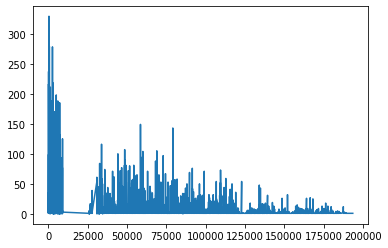

In [8]:
# importing the required module 
import matplotlib.pyplot as plt 
  
# x axis values 
x =df_movies["movieId"].unique()
# corresponding y axis values 
y = l
  
# plotting the points  
plt.plot(x,y)
plt.show()

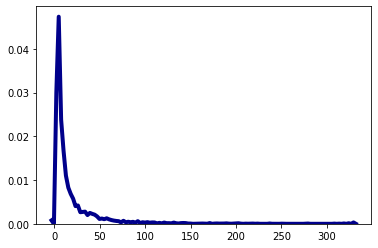

In [9]:
import seaborn as sns
sns.distplot(l, hist=False, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

<H3>Pre Processing-2</H3>

In [17]:
df_movies_cnt = pd.DataFrame(
            df_ratings.groupby('movieId').size(),
            columns=['count'])
popular_movies = list(set(df_movies_cnt.query('count >50').index))  # noqa
movies_filter = df_ratings.movieId.isin(popular_movies).values

In [19]:
df_users_cnt = pd.DataFrame(
            df_ratings.groupby('userId').size(),
            columns=['count'])
active_users = list(set(df_users_cnt.query('count >50').index))  # noqa
users_filter = df_ratings.userId.isin(active_users).values

In [23]:
df_ratings_filtered = df_ratings[movies_filter & users_filter]
#print(df_ratings_filtered)
print(df_ratings_filtered)

        userId  movieId  rating
0            1        1     4.0
1            1        3     4.0
2            1        6     4.0
3            1       47     5.0
4            1       50     5.0
...        ...      ...     ...
100657     610   106782     4.5
100672     610   109374     4.5
100673     610   109487     3.5
100701     610   112852     4.5
100742     610   122904     3.0

[36214 rows x 3 columns]


<H3>Spliting Data</H3>

In [13]:
import numpy as np
y=df_ratings_filtered["movieId"]
x=df_ratings_filtered.iloc[:,[0,2]]
#x=np.array(x)
#y=np.array(y)
x

,userId,rating
0,1,4.0
1,1,4.0
2,1,4.0
3,1,5.0
4,1,5.0
...,...,...
100657,610,4.5
100672,610,4.5
100673,610,3.5
100701,610,4.5


<H3>Testing different models</H3>

In [14]:
from surprise import SVD
from surprise import SVDpp,SlopeOne,NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate
from surprise import Dataset,Reader
benchmark = []
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(df_ratings_filtered,reader)
# Iterate over all algorithms
for algorithm in [SVD(), NormalPredictor(), KNNBaseline(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')     

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,0.829794,0.098792,1.672096
SVD,0.837312,1.326591,0.088039
BaselineOnly,0.838683,0.060030,0.096089
CoClustering,0.878172,0.648327,0.073812
NormalPredictor,1.389271,0.030599,0.065827


<H3> Forming Matrices</H3>

In [24]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
movie_user_mat = df_ratings_filtered.pivot(
            index='movieId', columns='userId', values='rating').fillna(0)
movie_user_mat1=df_ratings_filtered.pivot(
            index='userId', columns='movieId', values='rating').fillna(0)
movie_user_mat

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
7,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106782,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
109374,0.0,0.0,0.0,0.0,0.5,0.0,2.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
109487,0.0,0.0,0.0,0.0,0.5,0.0,4.0,0.0,0.0,4.5,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5


In [25]:
# create mapper from movie title to index
hashmap = {
            movie: i for i, movie in
            enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title)) # noqa
}

<H3> Creating Functions</H3>

In [17]:
from fuzzywuzzy import fuzz
import time

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [18]:
def fuzzy_matching(hashmap, fav_movie):
        match_tuple = []
        # get match
        for title, idx in hashmap.items():
            ratio = fuzz.ratio(title.lower(), fav_movie.lower())
            if ratio >= 60:
                match_tuple.append((title, idx, ratio))
        # sort
        match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
        if not match_tuple:
            print('Oops! No match is found')
        else:
            print('Found possible matches in our database: '
                  '{0}\n'.format([x[0] for x in match_tuple]))
            return match_tuple[0][1]

In [27]:
def inference(model, data, hashmap,
                   fav_movie, n_recommendations):
        # fit
        model.fit(data)
        # get input movie index
        print('You have input movie:', fav_movie)
        idx =fuzzy_matching(hashmap, fav_movie)
        # inference
        print('Recommendation system start to make inference')
        print('......\n')
        t0 = time.time()
        distances, indices = model.kneighbors(
            data[idx],
            n_neighbors=n_recommendations+1)
        # get list of raw idx of recommendations
        print(indices)
        raw_recommends = \
            sorted(
                list(
                    zip(
                        indices.squeeze().tolist(),
                        distances.squeeze().tolist()
                    )
                ),
                key=lambda x: x[1]
            )
        print('It took my system {:.2f}s to make inference \n\
              '.format(time.time() - t0))
        # return recommendation (movieId, distance)
        return raw_recommends,idx


<H3> Taking Input</H3>

In [31]:
fav_movie=input("enter your favorite movie=")

enter your favorite movie=toy story


<h3> Through Correlation</h3> 

In [32]:
h=fuzzy_matching(hashmap, fav_movie)
c=pd.DataFrame(movie_user_mat1.corr(method ='pearson'))
li=list(c.iloc[h]) 
final_list = [] 
for i in range(0, 6):  
    max1 = 0
    for j in range(len(li)):      
        if li[j] > max1: 
            max1 = li[j]; 
    final_list.append(li.index(max1)) 
    li.remove(max1); 
    
raw_recommends=final_list
raw_recommends
reverse_hashmap = {v: k for k, v in hashmap.items()}
for i, (idx) in enumerate(raw_recommends):
      print('{0}: {1}'.format(i+1, reverse_hashmap[idx]))

Found possible matches in our database: ['Toy Story (1995)', 'Toy Story 3 (2010)', 'Toy Story 2 (1999)']

1: Toy Story (1995)
2: Sleepy Hollow (1999)
3: Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
4: Hot Shots! Part Deux (1993)
5: Life Is Beautiful (La Vita è bella) (1997)
6: Young Frankenstein (1974)


<h3>Through KNN</h3>

In [33]:
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [34]:
from sklearn.neighbors import NearestNeighbors
raw_recommends,n =inference(
            NearestNeighbors(), movie_user_mat_sparse, hashmap,
            fav_movie, 6)
        # print results
reverse_hashmap = {v: k for k, v in hashmap.items()}
print('Recommendations for {}:'.format(fav_movie))
for i, (idx, dist) in enumerate(raw_recommends):
      print('{0}: {1}, with distance ''of {2}'.format(i+1, reverse_hashmap[idx], dist))


You have input movie: toy story
Found possible matches in our database: ['Toy Story (1995)', 'Toy Story 3 (2010)', 'Toy Story 2 (1999)']

Recommendation system start to make inference
......

[[  0 280  13  80  64 195 240]]
It took my system 0.00s to make inference 
              
Recommendations for toy story:
1: Toy Story (1995), with distance of 0.0
2: Toy Story 2 (1999), with distance of 40.902320861816406
3: Babe (1995), with distance of 43.31570053100586
4: Jurassic Park (1993), with distance of 43.60905838012695
5: Mask, The (1994), with distance of 43.806392669677734
6: Men in Black (a.k.a. MIB) (1997), with distance of 43.900455474853516
7: Bug's Life, A (1998), with distance of 44.25211715698242
